In [73]:
# configure spark variables
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F

# load up other dependencies
import re
import pandas as pd

In [74]:
spark = SparkSession.builder.appName("Web Log Analysis").getOrCreate()
#sc = SparkContext()
#sqlContext = SQLContext(sc)
#spark = SparkSession(sc)

### Loading and Viewing the Log Dataset & taking a look at the metadata of our dataframe

In [75]:
raw = spark.read.text("datasets/access.log")
raw = raw.filter(raw.value != '') # Removing the first empty line

In [76]:
raw.printSchema()

root
 |-- value: string (nullable = true)



In [77]:
# This output allows us to see the text for our log data’s schema that we will soon inspect.
raw.show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -                                                 |
|109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; 

### Data Wrangling - Data Parsing and Extraction with Regular Expressions

In [78]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
ts_pattern = r'\[(\d{2}\/\w{3}\/\d{4}:\d{2}:\d{2}:\d{2} .\d{4})]'
method_uri_protocol_pattern = r'([A-Z]{3,})\s(\S+)\s*(\S*)'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s(\d{3})\s(\d+)\s'

In [79]:
from pyspark.sql.functions import regexp_extract
print("*** CLEANING & TRANSFORMING LOG DATA INTO SPARK DATAFRAME ***")

logs_df = raw.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 2).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

*** CLEANING & TRANSFORMING LOG DATA INTO SPARK DATAFRAME ***
+---------------+--------------------+------+--------------------+--------+------+------------+
|           host|           timestamp|method|            endpoint|protocol|status|content_size|
+---------------+--------------------+------+--------------------+--------+------+------------+
|109.169.248.247|12/Dec/2015:18:25...|   GET|     /administrator/|HTTP/1.1|   200|        4263|
|109.169.248.247|12/Dec/2015:18:25...|  POST|/administrator/in...|HTTP/1.1|   200|        4494|
|    46.72.177.4|12/Dec/2015:18:31...|   GET|     /administrator/|HTTP/1.1|   200|        4263|
|    46.72.177.4|12/Dec/2015:18:31...|  POST|/administrator/in...|HTTP/1.1|   200|        4494|
| 83.167.113.100|12/Dec/2015:18:31...|   GET|     /administrator/|HTTP/1.1|   200|        4263|
| 83.167.113.100|12/Dec/2015:18:31...|  POST|/administrator/in...|HTTP/1.1|   200|        4494|
|   95.29.198.15|12/Dec/2015:18:32...|   GET|     /administrator/|HTTP/1.1

### Finding Missing Values

In [80]:
raw.filter(raw['value'].isNull()).count()

0

In [81]:
null_values_df = logs_df.filter(logs_df['host'].isNull() | 
              logs_df['timestamp'].isNull() |
              logs_df['method'].isNull() |
              logs_df['endpoint'].isNull() |
              logs_df['protocol'].isNull() |
              logs_df['status'].isNull() |
              logs_df['content_size'].isNull())

null_values_df.count()

6341

### Finding Null Counts

In [82]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as ssum

def count_null(col_name):
    return ssum(col(col_name).isNull().cast('integer')).alias(col_name)

print("*** COUNTING NULL VALUES IN THE DATA ***")

exprs = [count_null(col_name) for col_name in logs_df.columns]

logs_df.agg(*exprs).show()

*** COUNTING NULL VALUES IN THE DATA ***
+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|        6341|
+----+---------+------+--------+--------+------+------------+



### Fix the rows with null content_size

In [83]:
print("*** SETTING NULL VALUES TO ZERO ***")
logs_df = logs_df.na.fill({"content_size": 0})
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

*** SETTING NULL VALUES TO ZERO ***
+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



### Parsing timestamp to readable date

In [84]:
from pyspark.sql.functions import udf

month_dict = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_time(text):
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_dict[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

print("*** PARSING TIMESTAMP TO READABLE DATE ***")
udf_parse_time = udf(parse_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

*** PARSING TIMESTAMP TO READABLE DATE ***
+---------------+------+--------------------+--------+------+------------+--------------------+
|           host|method|            endpoint|protocol|status|content_size|                time|
+---------------+------+--------------------+--------+------+------------+--------------------+
|109.169.248.247|   GET|     /administrator/|HTTP/1.1|   200|        4263|2015-12-12 18:25:...|
|109.169.248.247|  POST|/administrator/in...|HTTP/1.1|   200|        4494|2015-12-12 18:25:...|
|    46.72.177.4|   GET|     /administrator/|HTTP/1.1|   200|        4263|2015-12-12 18:31:...|
|    46.72.177.4|  POST|/administrator/in...|HTTP/1.1|   200|        4494|2015-12-12 18:31:...|
| 83.167.113.100|   GET|     /administrator/|HTTP/1.1|   200|        4263|2015-12-12 18:31:...|
| 83.167.113.100|  POST|/administrator/in...|HTTP/1.1|   200|        4494|2015-12-12 18:31:...|
|   95.29.198.15|   GET|     /administrator/|HTTP/1.1|   200|        4263|2015-12-12 18:32:..

In [85]:
print("*** DATA SCHEMA ***")
logs_df.printSchema()

*** DATA SCHEMA ***
root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [86]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,109.169.248.247,GET,/administrator/,HTTP/1.1,200,4263,2015-12-12 18:25:11
1,109.169.248.247,POST,/administrator/index.php,HTTP/1.1,200,4494,2015-12-12 18:25:11
2,46.72.177.4,GET,/administrator/,HTTP/1.1,200,4263,2015-12-12 18:31:08
3,46.72.177.4,POST,/administrator/index.php,HTTP/1.1,200,4494,2015-12-12 18:31:08
4,83.167.113.100,GET,/administrator/,HTTP/1.1,200,4263,2015-12-12 18:31:25


In [87]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

### Analysis on Web Logs

### 1. HTTP Status Code Analysis

In [88]:
# Describe which HTTP status values appear in data and how many.

print("*** WHICH HTTP STATUS VALUES APPEAR IN DATA AND HOW MANY TIMES ***")
status_freq_df = logs_df \
                     .groupBy('status') \
                     .count() \
                     .sort('status') \
                     .cache()
print('Total distinct HTTP Status Codes:', status_freq_df.count())

status_freq_pd_df = (status_freq_df \
                         .toPandas() \
                         .sort_values(by=['count'], ascending=False))
status_freq_pd_df

*** WHICH HTTP STATUS VALUES APPEAR IN DATA AND HOW MANY TIMES ***
('Total distinct HTTP Status Codes:', 14)


,status,count
0,200,1157832
1,206,939929
8,404,227101
4,304,6330
12,500,3252
7,403,2222
2,301,619
3,303,247
6,401,153
13,501,143


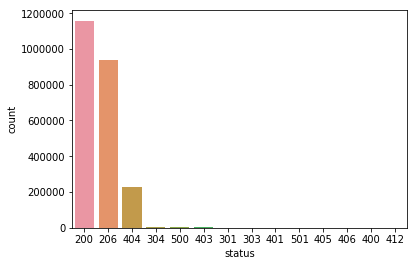

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.barplot(x='status', y='count', data=status_freq_pd_df, order=status_freq_pd_df['status']);

### Analyzing Frequent Hosts

In [90]:
print("*** HOSTS AND THEIR AVERAGE REQUEST ***")
host_sum_df =(logs_df \
               .groupBy('host') \
               .count() \
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

*** HOSTS AND THEIR AVERAGE REQUEST ***
+--------------+------+
|host          |count |
+--------------+------+
|198.50.156.189|167812|
|5.112.235.245 |166722|
|5.114.231.216 |158258|
|5.113.18.208  |157674|
|91.218.225.68 |134376|
|79.62.229.212 |114799|
|149.56.83.40  |97533 |
|5.114.64.184  |94043 |
|5.113.216.211 |89125 |
|158.69.5.181  |88875 |
+--------------+------+



### Top 20 Frequent EndPoints

In [91]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/apache-log/access.log,1002178
1,/administrator/index.php,582264
2,/administrator/,58434
3,/,24273
4,/templates/_system/css/general.css,21347
5,http://almhuette-raith.at/administrator/index.php,18009
6,/robots.txt,11959
7,/favicon.ico,9025
8,/wp-login.php,6547
9,/apache-log/,6402


### Top Ten Error Endpoints

In [92]:
not200_df = logs_df.filter(logs_df['status'] != 200)

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10))
                           
error_endpoints_freq_df.show(truncate=False)

+----------------------------------------------------------+------+
|endpoint                                                  |count |
+----------------------------------------------------------+------+
|/apache-log/access.log                                    |938011|
|/templates/_system/css/general.css                        |21347 |
|/favicon.ico                                              |9025  |
|/wp-login.php                                             |6547  |
|/apache-log/favicon.ico                                   |2917  |
|/apple-touch-icon.png                                     |1509  |
|/apple-touch-icon-precomposed.png                         |1459  |
|/apple-touch-icon-120x120-precomposed.png                 |1335  |
|/apple-touch-icon-120x120.png                             |1334  |
|/index.php?option=com_easyblog&view=dashboard&layout=write|806   |
+----------------------------------------------------------+------+



### Total number of Unique Hosts

In [93]:
print("*** NUMBER OF UNIQUE HOSTS IN THE ENTIRE LOG ***")
unique_host_count = logs_df.select('host').distinct().count()
print(unique_host_count)

*** NUMBER OF UNIQUE HOSTS IN THE ENTIRE LOG ***
40836


### Number of Unique Daily Hosts

In [94]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))

daily_hosts_df = (host_day_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,1,113876
1,2,26786
2,3,20291
3,4,49755
4,5,76700
5,6,55883
6,7,19931
7,8,113101
8,9,22953
9,10,95588


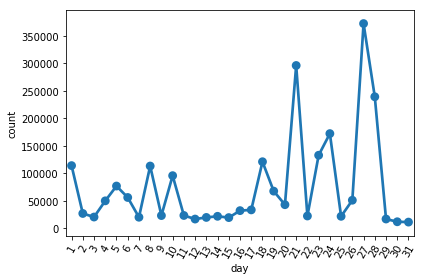

In [95]:
sns.pointplot(x='day', y='count', data=daily_hosts_df)
plt.xticks(rotation=60)
plt.tight_layout();

### Counting 404 Response Codes

In [96]:
not_found_df = logs_df.filter(logs_df['status'] == 404)
print('Total 404 responses: {}'.format(not_found_df.count()))

Total 404 responses: 227101


### Top Twenty 404 Response Code Endpoints

In [97]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+----------------------------------------------------------+-----+
|endpoint                                                  |count|
+----------------------------------------------------------+-----+
|/templates/_system/css/general.css                        |21347|
|/favicon.ico                                              |9025 |
|/wp-login.php                                             |6547 |
|/apache-log/favicon.ico                                   |2917 |
|/apple-touch-icon.png                                     |1509 |
|/apple-touch-icon-precomposed.png                         |1459 |
|/apple-touch-icon-120x120-precomposed.png                 |1335 |
|/apple-touch-icon-120x120.png                             |1334 |
|/index.php?option=com_easyblog&view=dashboard&layout=write|806  |
|/wp-login.php?action=register                             |726  |
|/index.php?option=com_users&view=registration             |495  |
|/icons/back.gif                                           |44

### Top Twenty 404 Response Code Hosts

In [98]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------+-----+
|host           |count|
+---------------+-----+
|79.62.229.212  |85479|
|91.218.225.68  |49669|
|199.19.249.196 |7512 |
|128.74.162.38  |2005 |
|185.100.222.119|1289 |
|194.63.141.238 |1154 |
|62.46.187.218  |1140 |
|205.167.170.15 |948  |
|158.64.79.8    |909  |
|52.22.118.215  |732  |
|158.64.79.7    |690  |
|87.242.64.194  |681  |
|46.105.96.187  |559  |
|178.210.90.90  |468  |
|46.188.125.44  |452  |
|94.60.38.241   |408  |
|85.10.113.129  |388  |
|188.23.224.79  |350  |
|185.25.63.136  |334  |
|162.242.255.101|298  |
+---------------+-----+



### 404 Errors per Day

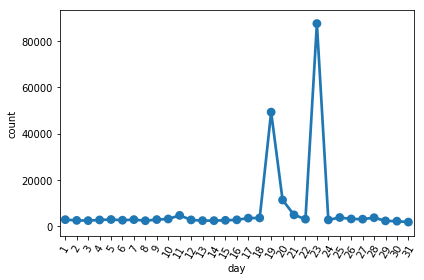

In [99]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
sns.pointplot(x='day', y='count', data=errors_by_date_sorted_pd_df)
plt.xticks(rotation=60)
plt.tight_layout();

### Top Three Days for 404 Errors

In [100]:
errors_by_date_sorted_df.sort("count", ascending=False).show(3)

+---+-----+
|day|count|
+---+-----+
| 23|87711|
| 19|49322|
| 20|11225|
+---+-----+
only showing top 3 rows



### Visualizing Hourly 404 Errors

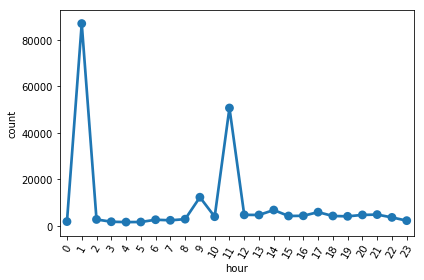

In [105]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

sns.pointplot(x='hour', y='count', data=hourly_avg_errors_sorted_pd_df)
plt.xticks(rotation=60)
plt.tight_layout();